<a href="https://colab.research.google.com/github/eduardofae/RL/blob/main/AT-01/01%20-%20MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-armed bandits

## imports

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from abc import ABC, abstractmethod

matplotlib.use('Agg')
%matplotlib inline

## Código-base do caça-níquel

A classe implementa um multiarmed bandit cuja recompensa média de cada braço é sorteada. Além disso, quando o braço é puxado (get_reward), a recompensa retornada é sorteada com uma gaussiana.

In [ ]:
class Environment:
    def __init__(self, k_arm=10, base_reward=0., seed=None):
        self.k = k_arm
        self.base_reward = base_reward
        self.seed = seed
        self.reset()

    def reset(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        # Real reward for each action
        self.q_true = np.random.randn(self.k) + self.base_reward
        self.best_action = np.argmax(self.q_true)

    def get_reward(self, action):
        # Generate the reward under N(real reward, 1)
        return np.random.randn() + self.q_true[action]

## Agentes

Cada agente representará uma política

### Classe abstrata do agente, representando a política

Você implementará cada política em uma subclasse diferente

In [ ]:
class Agent(ABC):
    def __init__(self, k_arm=10, initial_estimate=0.):
        self.k = k_arm
        self.initial = initial_estimate
        self.reset()

    def reset(self):
        # Estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial
        self.steps = 0
        self.previous_mean = 0

    @abstractmethod
    def act(self):
        pass

    @abstractmethod
    def update(self, action, reward):
        pass

### Epsilon-greedy com estimativa pela média amostral

Implemente o agente epsilon-greedy que atualiza as estimativas de valor de uma ação pela média amostral (soma das recompensas recebidas naquela ação / #de tentativas naquela ação)

In [ ]:
class EpsilonGreedySampleAverageAgent(Agent):
    def __init__(self, k_arm=10, epsilon=0.1, initial_estimate=0):
        super().__init__(k_arm, initial_estimate)
        self.epsilon = epsilon

    def act(self):
        # escreva aqui seu codigo para a escolha de ação epsilon-gulosa
        if np.random.rand() < self.epsilon:
          return np.random.randint(self.k)
        else:
          return np.argmax(self.q_estimation)

    def update(self, action, reward):
        # escreva aqui seu codigo para atualização do valor da ação escolhida
        self.steps += 1
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.steps


### Epsilon-greedy com atualização de passo constante

In [ ]:
class EpsilonGreedyConstantStepsizeAgent(Agent):
    def __init__(self, k_arm=10, epsilon=0.1, initial_estimate=0., step_size=0.1):
        super().__init__(k_arm, initial_estimate)
        self.epsilon = epsilon
        self.step_size = step_size

    def act(self):
        # escreva aqui seu codigo para a escolha de ação epsilon-gulosa
        if np.random.rand() < self.epsilon:
          return np.random.randint(self.k)
        else:
          return np.argmax(self.q_estimation)

    def update(self, action, reward):
        # escreva aqui seu codigo para atualização do valor da ação escolhida
        self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])


### Agente com atualização por subida de gradiente

In [ ]:
class GradientAgent(Agent):
    def __init__(self, k_arm=10, step_size=0.1, initial_estimate=0.):
        super().__init__(k_arm, initial_estimate)
        self.step_size = step_size

    def act(self):
        # escreva aqui seu codigo para a escolha de ação softmax
        prob = self.get_prob()
        return np.random.choice(self.k, p=prob)

    def get_prob(self, action=None):
      if action != None: return np.exp(self.q_estimation[action]) / np.sum(np.exp(self.q_estimation))
      return np.exp(self.q_estimation) / np.sum(np.exp(self.q_estimation))

    def update(self, action, reward):
        # escreva aqui seu codigo para atualização do valor da ação escolhida
        for act in range(self.k):
          if act == action:
            self.q_estimation[act] += self.step_size * (reward - self.previous_mean)*(1-self.get_prob(action=act))
          else:
            self.q_estimation[act] += self.step_size * (reward - self.previous_mean)*(self.get_prob(action=act))
        self.steps += 1
        self.previous_mean += (reward - self.previous_mean) / self.steps

## Código para executar uma simulação

Para usar, você deve informar quantas execuções independentes fará (runs), quantas iterações/tentativas haverá em cada execução (time), a lista de agentes (agents) e o multi-armed bandit (environment). A simulação retorna um vetor 2D (agentes x iterações) contendo a média de vezes que a melhor ação foi selecionada em cada iteração e outro vetor 2D (agentes x iterações) de recompensas médias por iteração.

In [ ]:
def simulate(runs, time, agents, environment):
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, agent in enumerate(agents):
        for r in trange(runs):
            environment.reset()
            agent.reset()
            for t in range(time):
                action = agent.act()
                reward = environment.get_reward(action)
                agent.update(action, reward)
                rewards[i, r, t] = reward
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

### Exemplo de simulação, gerando um gráfico

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-3015646166.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(rewards[0], label='$\epsilon = .1$')
100%|██████████| 50/50 [00:00<00:00, 190.69it/s]


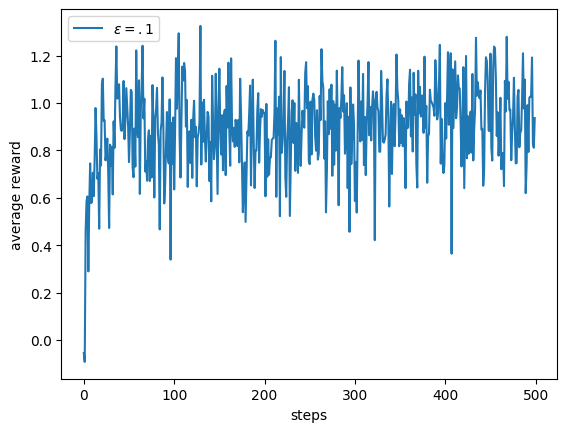

In [ ]:
def example_simulation(runs=50, time=500):
    env = Environment(k_arm=10)
    agents = [EpsilonGreedySampleAverageAgent(epsilon=0.1, initial_estimate=0)]

    best_action_counts, rewards = simulate(runs, time, agents, env)

    plt.plot(rewards[0], label='$\epsilon = .1$')
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.show()

example_simulation()

## Tarefas

1. Implementar as subclasses dos agentes
2. Em um multi-armed bandit com 10 alavancas e recompensa base de 0, gerar um gráfico comparando as políticas a seguir. Cada política deve ser executada 2000 vezes com 1000 tentativas em cada vez.
  * epsilon-greedy atualizado com média amostral com epsilon=0
  * epsilon-greedy atualizado com média amostral com epsilon=0.1
  * epsilon-greedy atualizado com média amostral com epsilon=0.01
3. Em um multi-armed bandit com 10 alavancas e recompensa base de 0, gerar um gráfico comparando as políticas a seguir (use alpha=0.1 para os agentes que atualizam estimativas usando tamanho de passo constante). Cada política deve ser executada 2000 vezes com 1000 tentativas em cada vez.
  * epsilon-greedy atualizado com média amostral com epsilon=0.01
  * epsilon-greedy atualizado com tamanho de passo constante com epsilon=0.01
  * gradiente
4. Crie uma nova classe modificando Environment, de forma a criar um multi-armed bandit não-estacionário (que muda ao longo do tempo). Em especial, faça os q_true iniciarem iguais (e.g. 0) e, a cada passo (step), cada um muda sendo somado a um valor sorteado por uma Normal(0,0.01). Reexecute a comparação da Tarefa 3, porém com 1000 repetições de 10 mil tentativas para cada agente.

## Tarefa 2

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1381022910.py:12: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(rewards[i], label=f'$\epsilon = {agents[i].epsilon}$')
100%|██████████| 2000/2000 [00:11<00:00, 171.25it/s]


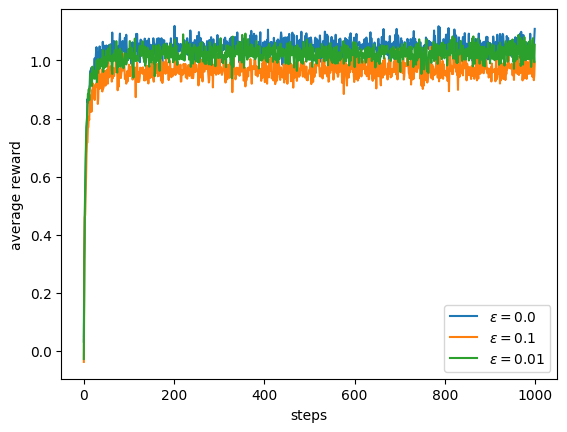

In [ ]:
runs = 2000
time = 1000

env = Environment(k_arm=10)
agents = [EpsilonGreedySampleAverageAgent(epsilon=0., initial_estimate=0),
          EpsilonGreedySampleAverageAgent(epsilon=0.1, initial_estimate=0),
          EpsilonGreedySampleAverageAgent(epsilon=0.01, initial_estimate=0)]

best_action_counts, rewards = simulate(runs, time, agents, env)

for i in range(len(agents)):
  plt.plot(rewards[i], label=f'$\epsilon = {agents[i].epsilon}$')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.show()

## Tarefa 3

100%|██████████| 2000/2000 [04:56<00:00,  6.74it/s]


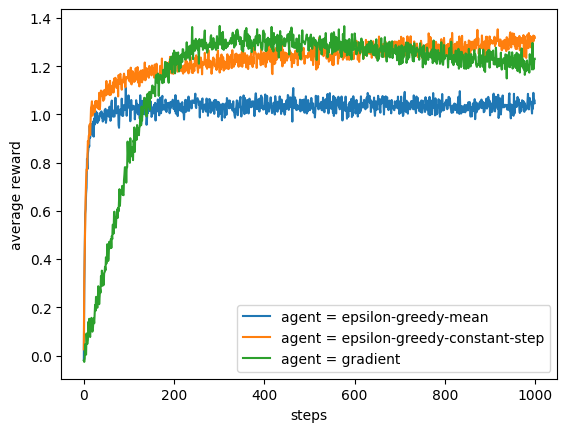

In [ ]:
runs = 2000
time = 1000

env = Environment(k_arm=10)
agents = [EpsilonGreedySampleAverageAgent(epsilon=0.01, initial_estimate=0),
          EpsilonGreedyConstantStepsizeAgent(epsilon=0.01, initial_estimate=0, step_size=0.1),
          GradientAgent(step_size=0.1, initial_estimate=0)]

best_action_counts, rewards = simulate(runs, time, agents, env)

agent_name = ['epsilon-greedy-mean', 'epsilon-greedy-constant-step', 'gradient']
for i in range(len(agents)):
  plt.plot(rewards[i], label=f'agent = {agent_name[i]}')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.show()

## Tarefa 4


In [ ]:
class Environment:
    def __init__(self, k_arm=10, base_reward=0., seed=None):
        self.k = k_arm
        self.base_reward = base_reward
        self.seed = seed
        self.reset()

    def reset(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        # Real reward for each action
        self.q_true = np.full(self.k, self.base_reward)
        self.best_action = np.argmax(self.q_true)

    def update(self):
      self.q_true += np.random.normal(0, 0.01, self.k)

    def get_reward(self, action):
        # Generate the reward under N(real reward, 1)
        return np.random.randn() + self.q_true[action]

In [ ]:
def simulate(runs, time, agents, environment):
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, agent in enumerate(agents):
        for r in trange(runs):
            environment.reset()
            agent.reset()
            for t in range(time):
                environment.update()
                action = agent.act()
                reward = environment.get_reward(action)
                agent.update(action, reward)
                rewards[i, r, t] = reward
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

100%|██████████| 1000/1000 [20:43<00:00,  1.24s/it]


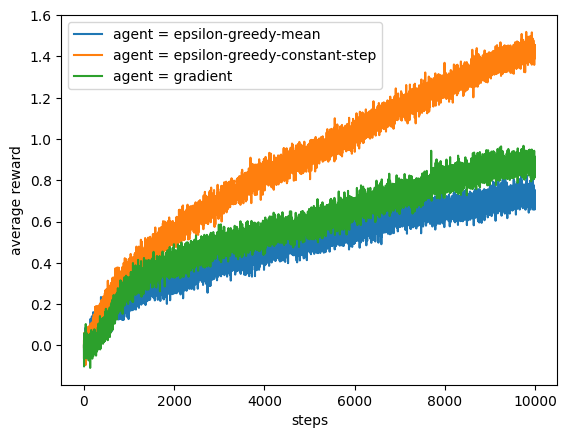

In [ ]:
runs = 1000
time = 10000

env = Environment(k_arm=10)
agents = [EpsilonGreedySampleAverageAgent(epsilon=0.01, initial_estimate=0),
          EpsilonGreedyConstantStepsizeAgent(epsilon=0.01, initial_estimate=0, step_size=0.1),
          GradientAgent(step_size=0.1, initial_estimate=0)]

best_action_counts, rewards = simulate(runs, time, agents, env)

agent_name = ['epsilon-greedy-mean', 'epsilon-greedy-constant-step', 'gradient']
for i in range(len(agents)):
  plt.plot(rewards[i], label=f'agent = {agent_name[i]}')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.show()